In [2]:
import pandas as pd
import numpy as np

In [3]:
meetups_data = pd.read_excel('meetups_data.xlsx')
meetups_data.head()

/Users/d.a.zimirev/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,meetup_template_id,name,users_total_08.24,users_attended_08.24,users_total_09.24,users_attended_09.24,users_total_10.24,users_attended_10.24,users_total_11.24,users_attended_11.24,users_total_12.24,users_attended_12.24,users_total_01.25,users_attended_01.25,users_total_02.25,users_attended_02.25,users_total_03.25,users_attended_03.25,users_total_04.25,users_attended_04.25
0,1644,"Вебинар ""Manager. Digital. День 3""",132,37,151,49,145,52,67,27,25,13,25,8,13,12,20,14,2,0
1,2336,"Вебинар ""Как успокоить клиента. КК""",0,0,6,6,2,2,0,0,6,6,87,13,52,0,61,6,22,0
2,2674,"Вебинар ""Общаемся просто и понятно""",0,0,25,1,343,33,370,43,142,3,282,17,345,25,436,18,193,3
3,2798,"Вебинар ""ОСАГО""",0,0,0,0,14,2,0,0,0,0,0,0,0,0,0,0,0,0
4,2817,"Вебинар ""Сервисы Города. Лента""",0,0,12,0,2,2,0,0,15,1,4,1,0,0,19,0,10,0


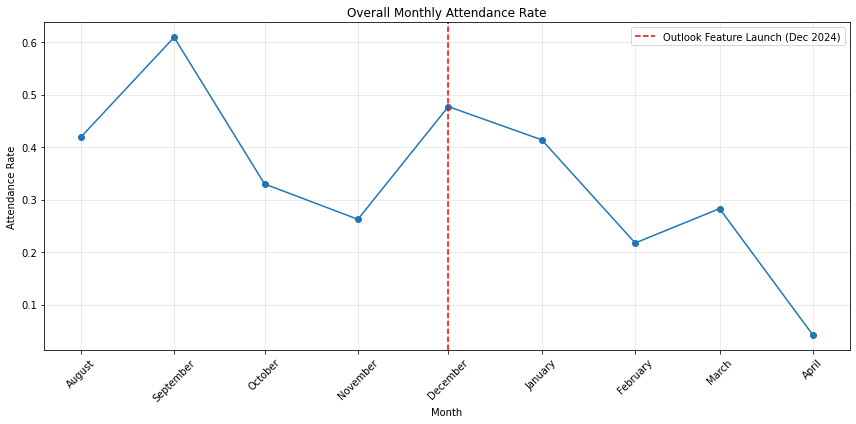


Monthly Attendance Data:
        Date       MonthName  TotalRegistered  TotalAttended  AttendanceRate
0 2024-08-01     August 2024              172             72        0.418605
1 2024-09-01  September 2024             1522            927        0.609067
2 2024-10-01    October 2024             2556            843        0.329812
3 2024-11-01   November 2024             1562            410        0.262484
4 2024-12-01   December 2024             1006            480        0.477137
5 2025-01-01    January 2025             1114            461        0.413824
6 2025-02-01   February 2025             1150            250        0.217391
7 2025-03-01      March 2025              983            278        0.282808
8 2025-04-01      April 2025              310             13        0.041935

Data prepared for ITS model:
        Date  AttendanceRate  time  intervention  time_since_intervention
0 2024-08-01        0.418605     0             0                        0
1 2024-09-01        0.6090

/Users/d.a.zimirev/.local/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  res = hypotest_fun_out(*samples, **kwds)


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices # For easier formula-based model specification

# --- 1. Data Loading and Preparation ---
# Load the data (assuming it's already loaded as meetups_data)
# meetups_data = pd.read_excel('meetups_data.xlsx')

# Identify month columns
month_pairs = [
    ('08.24', 'August 2024'), ('09.24', 'September 2024'), ('10.24', 'October 2024'),
    ('11.24', 'November 2024'), ('12.24', 'December 2024'), ('01.25', 'January 2025'),
    ('02.25', 'February 2025'), ('03.25', 'March 2025'), ('04.25', 'April 2025')
]

monthly_summary = []

for month_code, month_name in month_pairs:
    total_col = f'users_total_{month_code}'
    attended_col = f'users_attended_{month_code}'

    if total_col in meetups_data.columns and attended_col in meetups_data.columns:
        total_registered = meetups_data[total_col].sum()
        total_attended = meetups_data[attended_col].sum()

        attendance_rate = (total_attended / total_registered) if total_registered > 0 else 0
        
        year = int("20" + month_code.split('.')[1])
        month_num = int(month_code.split('.')[0])
        
        monthly_summary.append({
            'Date': pd.to_datetime(f'{year}-{month_num:02d}-01'),
            'MonthName': month_name,
            'TotalRegistered': total_registered,
            'TotalAttended': total_attended,
            'AttendanceRate': attendance_rate
        })

# Create DataFrame from summary
attendance_df = pd.DataFrame(monthly_summary)
attendance_df = attendance_df.sort_values(by='Date').reset_index(drop=True)

# --- 2. Exploratory Data Analysis (EDA) & Visualization ---
plt.figure(figsize=(12, 6))
plt.plot(attendance_df['Date'], attendance_df['AttendanceRate'], marker='o', linestyle='-')
plt.title('Overall Monthly Attendance Rate')
plt.xlabel('Month')
plt.ylabel('Attendance Rate')
# Mark intervention point: Feature introduced in Dec 2024
# The first data point for "post" is Dec 2024, which is index 4 if Aug 2024 is index 0
intervention_date = pd.to_datetime('2024-12-01')
plt.axvline(intervention_date, color='red', linestyle='--', label='Outlook Feature Launch (Dec 2024)')
plt.xticks(attendance_df['Date'], attendance_df['MonthName'].str.split().str[0], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nMonthly Attendance Data:")
print(attendance_df)

# --- 3. Statistical Analysis - Interrupted Time Series (ITS) ---
# Create variables for ITS model
attendance_df['time'] = np.arange(len(attendance_df))
# Intervention: 0 before Dec 2024, 1 from Dec 2024 onwards
attendance_df['intervention'] = (attendance_df['Date'] >= intervention_date).astype(int)
# TimeSinceIntervention: counts months from intervention (0 before, 0 for Dec, 1 for Jan, etc.)
attendance_df['time_since_intervention'] = 0
intervention_started_index = attendance_df[attendance_df['Date'] >= intervention_date].index[0]
attendance_df.loc[intervention_started_index:, 'time_since_intervention'] = np.arange(len(attendance_df) - intervention_started_index)


print("\nData prepared for ITS model:")
print(attendance_df[['Date', 'AttendanceRate', 'time', 'intervention', 'time_since_intervention']])

# Fit the OLS model for ITS
# Using patsy for easier formula definition, similar to R
# Ensure 'AttendanceRate' is not zero or too close to zero variance
if attendance_df['AttendanceRate'].nunique() > 1 and attendance_df['AttendanceRate'].var() > 1e-9 :
    y, X = dmatrices('AttendanceRate ~ time + intervention + time_since_intervention', 
                     data=attendance_df, return_type='dataframe')
    
    its_model = sm.OLS(y, X)
    its_results = its_model.fit()
    
    print("\n--- Interrupted Time Series Analysis Results ---")
    print(its_results.summary())

    # --- 4. Drawing Conclusions (based on ITS results) ---
    # Interpretation of coefficients:
    # Intercept: Baseline attendance rate at time 0 (adjusted for other terms)
    # time: Baseline trend before intervention
    # intervention: Immediate change in attendance rate level after intervention
    # time_since_intervention: Change in trend (slope) after intervention

    p_value_intervention = its_results.pvalues['intervention']
    p_value_time_since_intervention = its_results.pvalues['time_since_intervention']
    coef_intervention = its_results.params['intervention']
    coef_time_since_intervention = its_results.params['time_since_intervention']

    print("\n--- Key Findings from ITS Model: ---")
    print(f"Immediate effect of intervention (level change): Coef = {coef_intervention:.4f}, P-value = {p_value_intervention:.4f}")
    if p_value_intervention < 0.05:
        print("  -> Statistically significant immediate change in attendance rate.")
    else:
        print("  -> No statistically significant immediate change in attendance rate.")

    print(f"Change in trend after intervention (slope change): Coef = {coef_time_since_intervention:.4f}, P-value = {p_value_time_since_intervention:.4f}")
    if p_value_time_since_intervention < 0.05:
        print("  -> Statistically significant change in the attendance rate trend post-intervention.")
    else:
        print("  -> No statistically significant change in the attendance rate trend post-intervention.")
        
    print("\nOverall Conclusion Guidance:")
    print("To make a final conclusion, consider the significance and direction of these coefficients.")
    print("A positive and significant 'intervention' coefficient suggests an immediate jump in attendance.")
    print("A positive and significant 'time_since_intervention' coefficient suggests attendance rates started to improve (or decline less steeply) after the feature launch.")
    print("Remember to acknowledge limitations like the short time series and absence of a control group.")

else:
    print("\nCould not perform ITS analysis: AttendanceRate has insufficient variance or unique values.")
    print("This might happen if attendance is always 0% or 100%, or doesn't change much over the period.")
